# Group 14 - SPAM CLASSIFICATION

In [1]:
#Importing required libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
import wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data file
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [3]:
#Dropping unncessary data columns and providing labels to other columns
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df.head()

label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

# Data Visualization

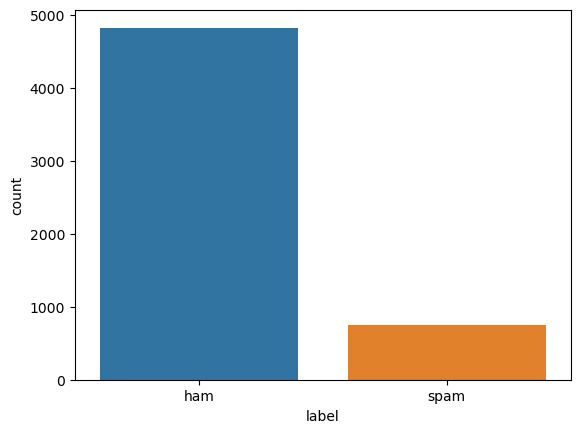

In [4]:
#Plotting count of spam and ham labels in datasets
sns.countplot(x=df['label'])
plt.show()

In [5]:
#Presenting the percentage of spam and ham labels in dataset
fig = px.pie(df.label.value_counts(),labels='index', values='label', color="label", color_discrete_sequence=["#871fff","#ffa78c"] )
fig.show()

In [6]:
#Showing length of each message
df['length'] = df['Text'].apply(len)
df.head()

label                                               Text  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

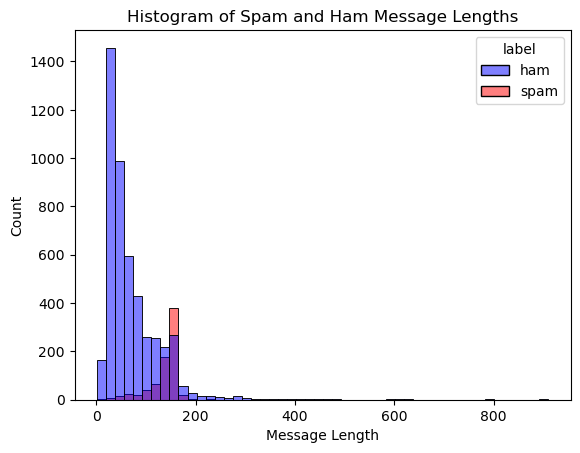

In [7]:
#Visualization the length the spam and ham messages
sns.histplot(df, x='length', hue='label', bins=50, kde=False, palette={'ham': 'blue', 'spam': 'red'})

# Add labels and title
plt.xlabel('Message Length')
plt.title('Histogram of Spam and Ham Message Lengths')

# Show the plot
plt.show()

In [8]:
#Creating world cloud for spam and ham messages
data_ham  = df[df['label'] == "ham"].copy()
data_spam = df[df['label'] == "spam"].copy()

def show_wordcloud(df, title):
    text = ' '.join(df['Text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#ffa78c", width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

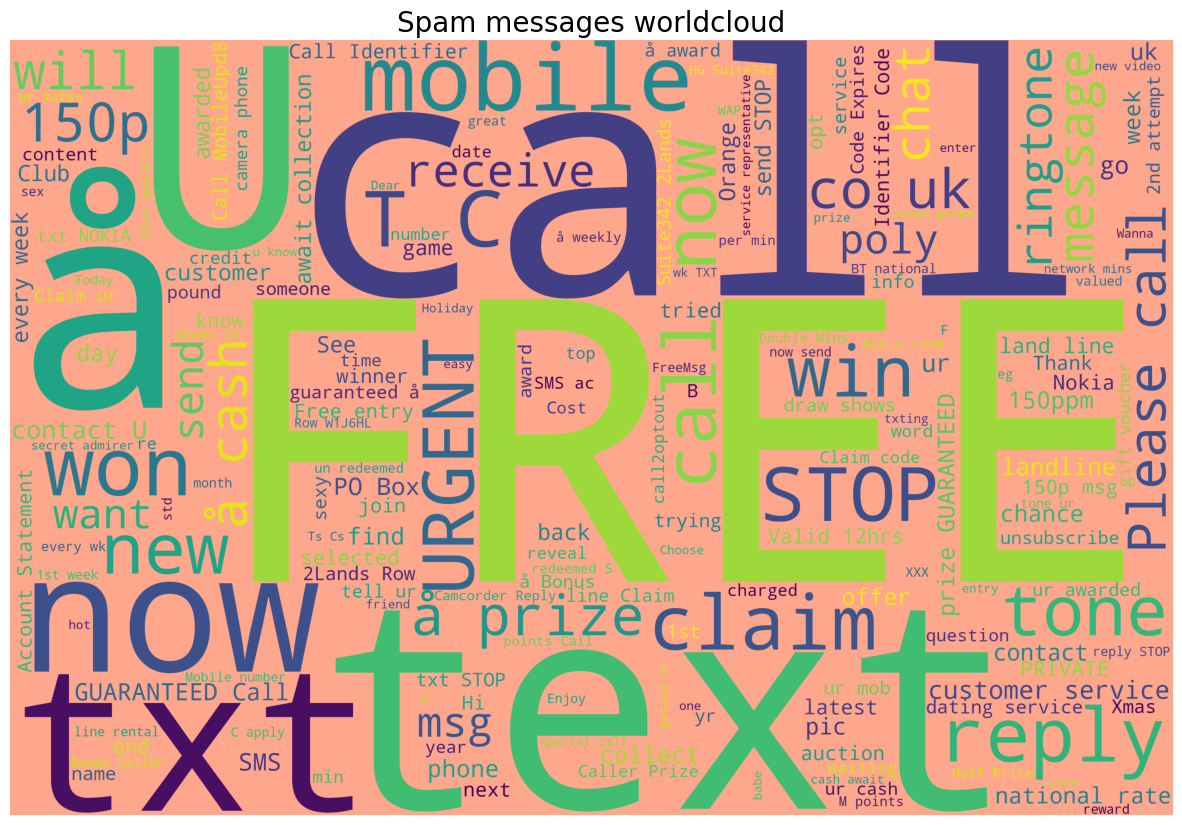

In [9]:
show_wordcloud(data_spam, "Spam messages worldcloud")

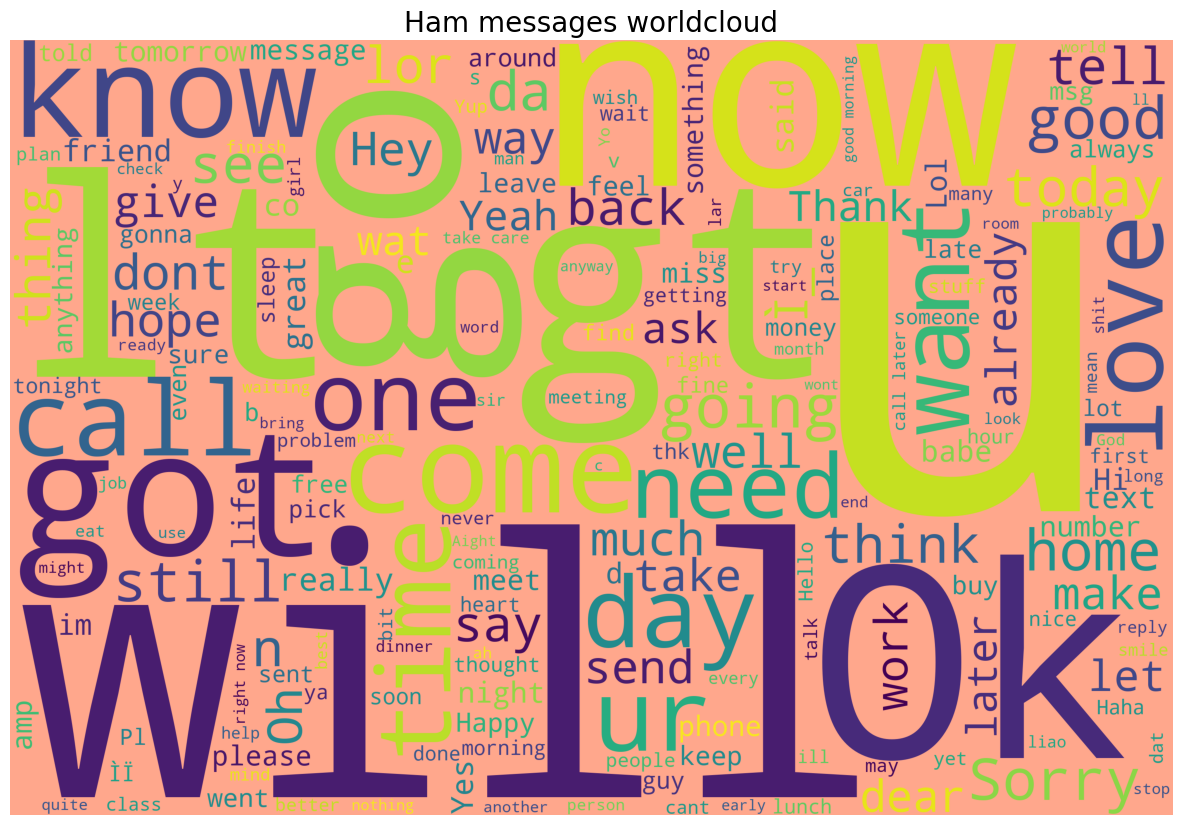

In [10]:
show_wordcloud(data_ham, "Ham messages worldcloud")

# Data Pre Processing

In [11]:
#Providing values to the labels
df['label_enc'] = df['label'].map({'ham':0,'spam':1})

In [12]:
# Replace email address with 'emailaddress'
df['Text'] = df['Text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['Text'] = df['Text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['Text'] = df['Text'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['Text'] = df['Text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['Text'] = df['Text'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['Text'] = df['Text'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['Text'] = df['Text'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['Text'] = df['Text'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['Text'] = df['Text'].str.lower()

In [13]:
#Remove stop words from Text
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [14]:
sms_df = df['Text']

# creating a bag-of-words model
all_words = []
for sms in sms_df:
    words = word_tokenize(sms)
    for w in words:
        all_words.append(w)

all_words = nltk.FreqDist(all_words)
print('Number of words: {}'.format(len(all_words)))

Number of words: 7870


In [15]:
print('Number of words: {}'.format(len(all_words)))

Number of words: 7870


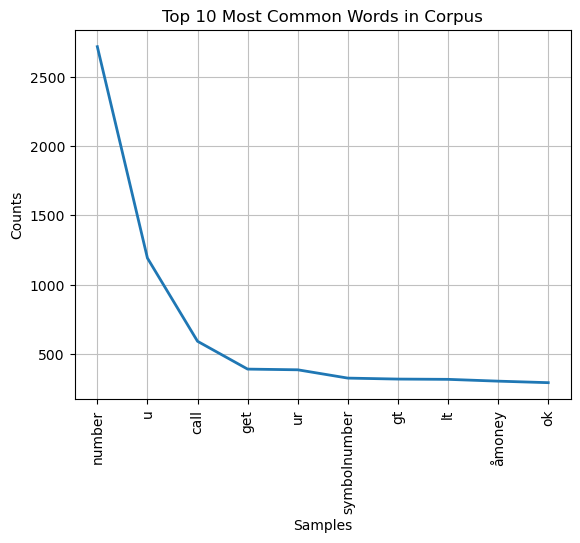

In [16]:
all_words.plot(10, title='Top 10 Most Common Words in Corpus');

# Data Model Implementations

In [17]:
# Splitting data for Training and testing 
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'], test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3343,), (3343,), (2229,), (2229,))

In [18]:
# transform the text data to feature vectors that can be used as input to the 4 models below

feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase=True)

X_train_vec = feature_extraction.fit_transform(X_train)
X_test_vec = feature_extraction.transform(X_test)

# convert Y_train and Y_test values as integers

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [19]:
#Naive Baye's Algorith implementation 
model_1 = MultinomialNB()
model_1.fit(X_train_vec,y_train)

MultinomialNB()

In [20]:
#Train Data Classification Summary for Naive's Bayes Algorithm
nb_train_accuracy = accuracy_score(y_train,model_1.predict(X_train_vec))
print(f"Accuracy using Naive's Bayes for train data: {nb_train_accuracy * 100:.2f}%")

nb_train_f1_score = f1_score(y_train,model_1.predict(X_train_vec))
print('F1 score using Naive Bayes for train data: %f' % nb_train_f1_score)

print(classification_report(y_train, model_1.predict(X_train_vec)))

Accuracy using Naive's Bayes for train data: 98.47%
F1 score using Naive Bayes for train data: 0.939645
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2895
           1       1.00      0.89      0.94       448

    accuracy                           0.98      3343
   macro avg       0.99      0.94      0.97      3343
weighted avg       0.99      0.98      0.98      3343



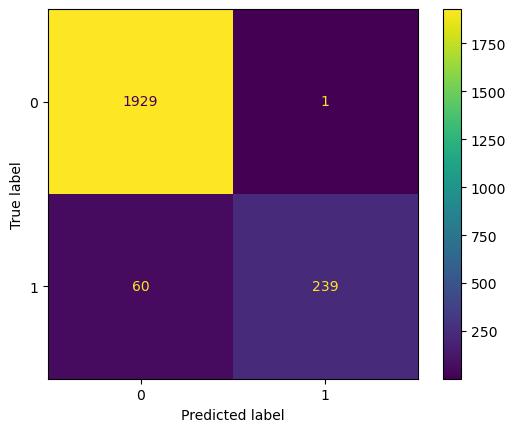

In [21]:
#Confusion Matrix for Naive Baye's algorithm
predictions = model_1.predict(X_test_vec)
cm = confusion_matrix(y_test, predictions, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()
plt.show()

In [22]:
#Test Data Classification Summary for Naive's Bayes Algorithm
nb_test_accuracy = accuracy_score(y_test,model_1.predict(X_test_vec))
print(f"Accuracy using Naive's Bayes for test data: {nb_test_accuracy * 100:.2f}%")

nb_test_f1_score = f1_score(y_test,model_1.predict(X_test_vec))
print('F1 score using Naive Bayes for test data: %f' % nb_test_f1_score)

print(classification_report(y_test, model_1.predict(X_test_vec)))

Accuracy using Naive's Bayes for test data: 97.26%
F1 score using Naive Bayes for test data: 0.886827
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1930
           1       1.00      0.80      0.89       299

    accuracy                           0.97      2229
   macro avg       0.98      0.90      0.94      2229
weighted avg       0.97      0.97      0.97      2229



In [23]:
#Logistics Regression Implementation
model_2 = LogisticRegression()
model_2.fit(X_train_vec,y_train)

LogisticRegression()

In [24]:
#Train Data Classification Summary for Logistic Regression Algorithm
lr_train_accuracy = accuracy_score(y_train,model_2.predict(X_train_vec))
print(f"Accuracy using Logistics Regression for train data: {lr_train_accuracy * 100:.2f}%")

lr_train_f1_score = f1_score(y_train,model_2.predict(X_train_vec))
print('F1 score using Logistics Regression for train data: %f' % lr_train_f1_score)

print(classification_report(y_train, model_2.predict(X_train_vec)))

Accuracy using Logistics Regression for train data: 97.25%
F1 score using Logistics Regression for train data: 0.887805
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2895
           1       0.98      0.81      0.89       448

    accuracy                           0.97      3343
   macro avg       0.98      0.90      0.94      3343
weighted avg       0.97      0.97      0.97      3343



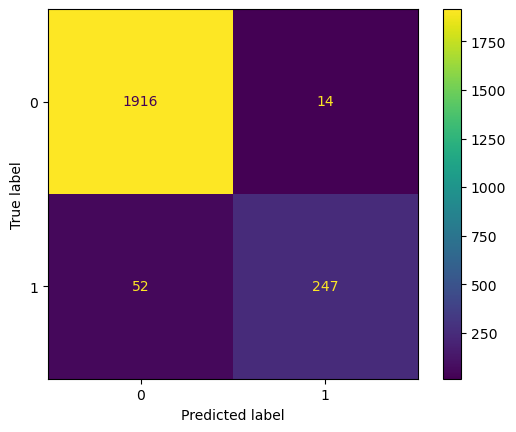

In [25]:
#Confusion Matrix for Logistic algorithm
predictions = model_2.predict(X_test_vec)
cm = confusion_matrix(y_test, predictions, labels=model_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot()
plt.show()

In [26]:
#Test Data Classification Summary for Logistic Regression Algorithm
lr_test_accuracy = accuracy_score(y_test,model_2.predict(X_test_vec))
print(f"Accuracy using Logistics Regression for test data: {lr_test_accuracy * 100:.2f}%")

lr_test_f1_score = f1_score(y_test,model_2.predict(X_test_vec))
print('F1 score using Logistics Regression for test data: %f' % lr_test_f1_score)

print(classification_report(y_test, model_2.predict(X_test_vec)))

Accuracy using Logistics Regression for test data: 97.04%
F1 score using Logistics Regression for test data: 0.882143
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1930
           1       0.95      0.83      0.88       299

    accuracy                           0.97      2229
   macro avg       0.96      0.91      0.93      2229
weighted avg       0.97      0.97      0.97      2229



In [27]:
#KNN Model Implementation
model_3= KNeighborsClassifier(n_neighbors=5)
model_3.fit(X_train_vec,y_train)

KNeighborsClassifier()

In [28]:
#Train Data Classification Summary for KNN Algorithm
knn_train_accuracy = accuracy_score(y_train,model_3.predict(X_train_vec))
print(f"Accuracy using KNN for train data: {knn_train_accuracy * 100:.2f}%")

knn_train_f1_score = f1_score(y_train,model_3.predict(X_train_vec))
print('F1 score using KNN for train data: %f' % knn_train_f1_score)

print(classification_report(y_train, model_3.predict(X_train_vec)))

Accuracy using KNN for train data: 91.68%
F1 score using KNN for train data: 0.550162
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2895
           1       1.00      0.38      0.55       448

    accuracy                           0.92      3343
   macro avg       0.96      0.69      0.75      3343
weighted avg       0.92      0.92      0.90      3343



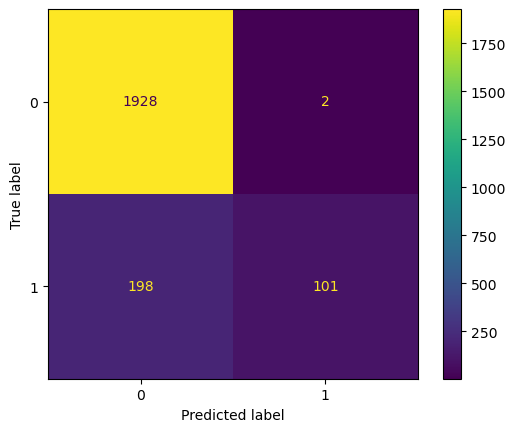

In [29]:
#Confusion Matrix for KNN algorithm
predictions = model_3.predict(X_test_vec)
cm = confusion_matrix(y_test, predictions, labels=model_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot()
plt.show()

In [30]:
#Test Data Classification Summary for KNN Algorithm
knn_test_accuracy = accuracy_score(y_test,model_3.predict(X_test_vec))
print(f"Accuracy using KNN for test data: {knn_test_accuracy * 100:.2f}%")

knn_test_f1_score = f1_score(y_test,model_3.predict(X_test_vec))
print('F1 score using KNN for test data: %f' % knn_test_f1_score)

print(classification_report(y_test, model_3.predict(X_test_vec)))

Accuracy using KNN for test data: 91.03%
F1 score using KNN for test data: 0.502488
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1930
           1       0.98      0.34      0.50       299

    accuracy                           0.91      2229
   macro avg       0.94      0.67      0.73      2229
weighted avg       0.92      0.91      0.89      2229



In [31]:
#Support Vector Model Implementation
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
tuned_parameters = {'kernel':['linear','rbf'],'gamma':[1e-3,1e-4], 'C':[1,10,100,1000]}

model_4 = GridSearchCV(svm.SVC(),tuned_parameters)
model_4.fit(X_train_vec,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [32]:
#Train Data Classification Summary for SVM Algorithm
svc_train_accuracy = accuracy_score(y_train,model_4.predict(X_train_vec))
print(f"Accuracy using SVC for train data: {svc_train_accuracy * 100:.2f}%")

svc_train_f1_score = f1_score(y_train, model_4.predict(X_train_vec))
print('F1 score using SVC for train data: %f' % svc_train_f1_score)

print(classification_report(y_test, model_4.predict(X_test_vec)))

Accuracy using SVC for train data: 99.94%
F1 score using SVC for train data: 0.997773
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1930
           1       0.96      0.94      0.95       299

    accuracy                           0.99      2229
   macro avg       0.97      0.97      0.97      2229
weighted avg       0.99      0.99      0.99      2229



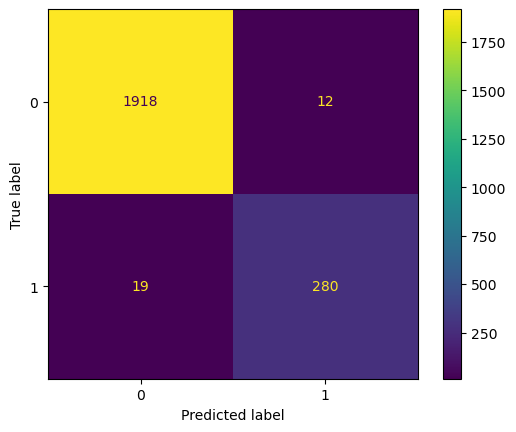

In [33]:
#Confusion Matrix for SVM algorithm
predictions = model_4.predict(X_test_vec)
cm = confusion_matrix(y_test, predictions, labels=model_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_4.classes_)
disp.plot()
plt.show()

In [34]:
#Test Data Classification Summary for SVC Algorithm
svc_test_accuracy = accuracy_score(y_test,model_4.predict(X_test_vec))
print(f"Accuracy using SVC for test data: {svc_test_accuracy * 100:.2f}%")

svc_test_f1_score = f1_score(y_test, model_4.predict(X_test_vec))
print('F1 score using SVC for test data: %f' % svc_test_f1_score)

print(classification_report(y_test, model_4.predict(X_test_vec)))

Accuracy using SVC for test data: 98.61%
F1 score using SVC for test data: 0.947547
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1930
           1       0.96      0.94      0.95       299

    accuracy                           0.99      2229
   macro avg       0.97      0.97      0.97      2229
weighted avg       0.99      0.99      0.99      2229



(0.9, 1.0)

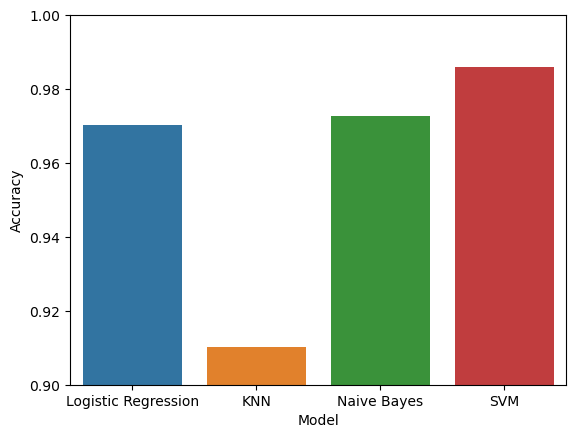

In [35]:
#Accuracy comparison using barchart for all models
data = [['Logistic Regression',lr_test_accuracy],['KNN',knn_test_accuracy],['Naive Bayes',nb_test_accuracy],['SVM',svc_test_accuracy]]
df_accuracy = pd.DataFrame(data, columns=['Model','Accuracy'])
plt = sns.barplot(x='Model', y='Accuracy',data=df_accuracy)
plt.set_ylim(0.9, 1)


(0.4, 1.0)

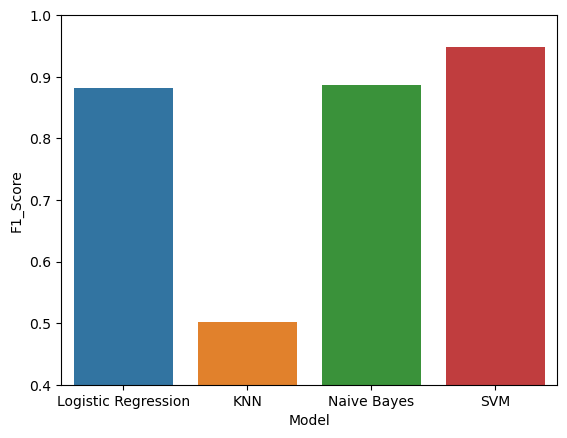

In [36]:
#F1-score comparison using barchart for all models
data = [['Logistic Regression',lr_test_f1_score],['KNN',knn_test_f1_score],['Naive Bayes',nb_test_f1_score],['SVM',svc_test_f1_score]]
df_f1_score = pd.DataFrame(data, columns=['Model','F1_Score'])
plt = sns.barplot(x='Model', y='F1_Score',data=df_f1_score)
plt.set_ylim(0.4, 1)

In [37]:
#Testing models on new input data
input_data = ["FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"]

input_data_features = feature_extraction.transform(input_data)

prediction = model_2.predict(input_data_features)
print(prediction)

if (prediction[0]==1):
  print('Ham mail')

else:
  print('Spam mail')

[0]
Spam mail
